<a href="https://colab.research.google.com/github/eemayes2/IE517MLF_Group_project/blob/main/Group_Project_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Data Description:

*MLF_GP1_CreditScore contains 1700 observations of 26 financial and accounting metrics changes for a set of firms in several different industries.
The Class label is the Moody's credit rating assigned to the firm in the following quarter.  Certain ratings are considered "Investment Grade" (=1), other ratings are not (=0) and consequently may not be held in certain institutional portfolios (pension plans, etc.)*

*This is a classification problem; using the features, X, and the machine learning techniques from this class, classify the Moody's score (multiclass classification) and the Investment Grade (binary classification). Not both at the same time!  Two models - one multiclass, one binary class.*

In [ ]:
#Read in the data
df = pd.read_csv('gdrive/MyDrive/IE 517_Group Project/Datasets/MLF_GP1_CreditScore.csv', sep = ',')
df.head()

,Sales/Revenues,Gross Margin,EBITDA,EBITDA Margin,Net Income Before Extras,Total Debt,Net Debt,LT Debt,ST Debt,Cash,Free Cash Flow,Total Debt/EBITDA,Net Debt/EBITDA,Total MV,Total Debt/MV,Net Debt/MV,CFO/Debt,CFO,Interest Coverage,Total Liquidity,Current Liquidity,Current Liabilities,EPS Before Extras,PE,ROA,ROE,InvGrd,Rating
0,-0.005496,0.030763,0.018885,0.024515,0.146849,-0.029710,-0.019296,-0.042648,0.049875,-0.133716,0.352997,-0.047694,-0.037474,0.263605,-0.232129,-0.223883,0.101245,0.068526,0.136748,0.392143,-0.184887,0.062781,0.148305,0.100409,0.163266,0.102521,1,A1
1,-0.005496,0.030763,0.088716,0.094733,0.146849,-0.029710,-0.019296,-0.042648,0.049875,-0.133716,0.352997,-0.108776,-0.099211,0.045420,-0.071864,-0.061909,0.101245,0.068526,0.214657,0.392143,-0.184887,0.062781,0.148305,-0.089598,0.163266,0.102521,1,A1
2,-0.007045,0.023159,0.088716,0.096440,0.108590,0.039410,0.034268,0.009059,0.250371,0.101315,0.500174,-0.045288,-0.050011,0.060519,-0.019903,-0.024748,0.027638,0.068136,0.205290,0.483257,-0.017877,0.121357,0.110656,-0.045142,0.105711,0.103378,1,A1
3,-0.009396,0.028400,0.088716,0.099046,0.146137,0.030071,0.036938,-0.016964,0.356994,-0.052606,0.551592,-0.053866,-0.047559,0.142160,-0.098139,-0.092127,0.042437,0.073784,0.232991,0.996955,-0.122017,0.079051,0.151639,-0.008231,0.162421,0.132295,1,A1
4,-0.009009,0.027714,0.088716,0.098611,0.123500,0.024224,0.034445,-0.034132,0.461894,-0.090869,0.753321,-0.059237,-0.049849,0.147989,-0.107808,-0.098904,0.106052,0.132845,0.172906,1.711426,-0.161561,0.084319,0.130435,0.015528,0.156427,0.225144,1,A1


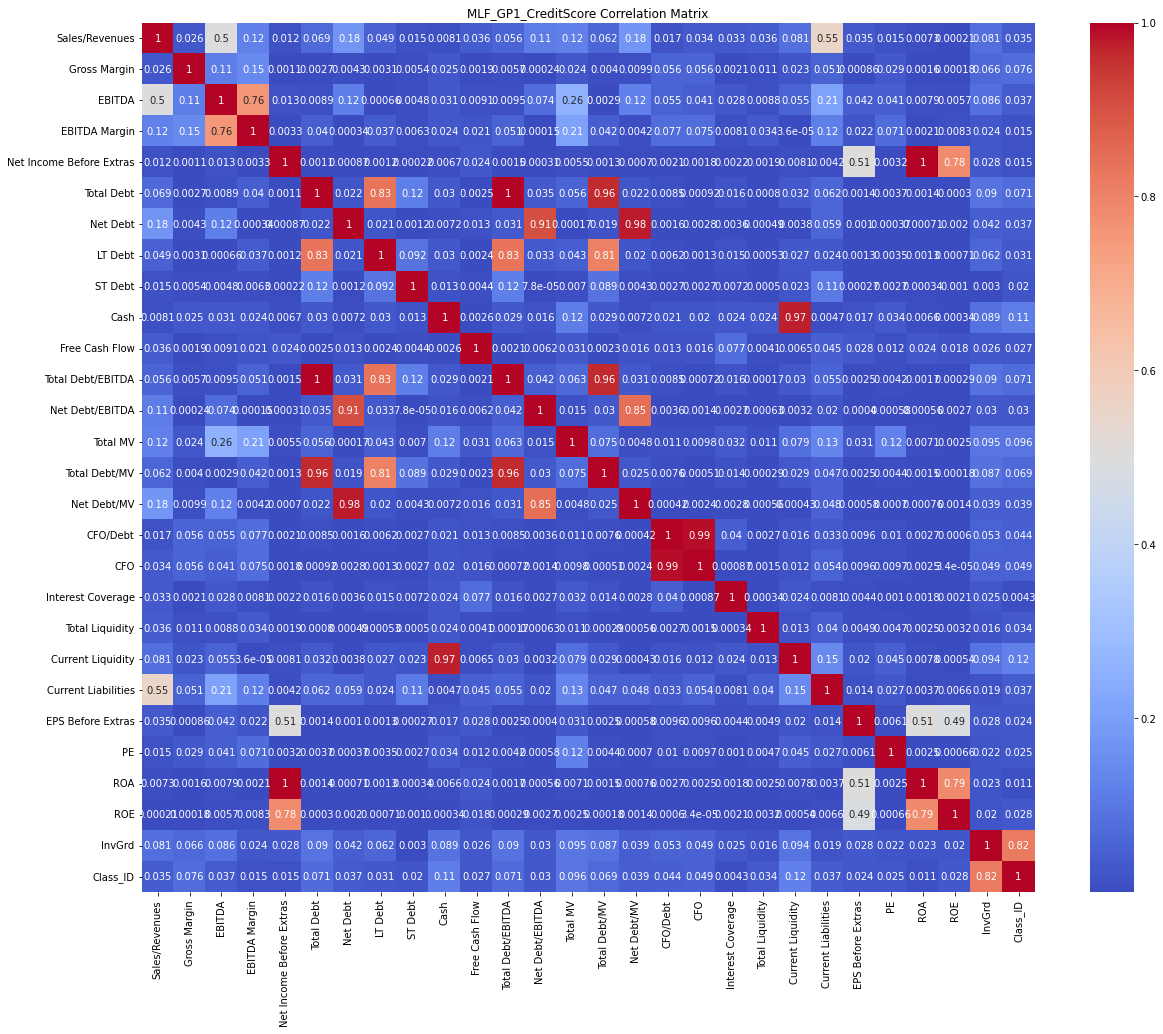

In [ ]:
# Plot the absolute value of the corr heatmap
corr_matrix = df.corr().abs()
plt.figure(figsize = (20,16))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm')
plt.title("MLF_GP1_CreditScore Correlation Matrix")
plt.show()

## Binary Model
i.e.- target is "InvGrd"

## SMOTE to balance classes

In [ ]:
#Set up X and Y columns. 
X = df.drop(columns = ['InvGrd', 'Rating'])
Y = df['InvGrd']

In [ ]:
#First, don't do any feature engineering or selection, let's see how it does
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify = Y)

In [ ]:
# summarize class distribution
counter = Counter(y_train)
print(counter)

Counter({1: 1030, 0: 330})


In [ ]:
# transform the dataset
oversample = SMOTE(random_state=12)
X_train, y_train = oversample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# summarize the new class distribution
counter_SMOTE = Counter(y_train)
print(counter_SMOTE)

Counter({1: 1030, 0: 1030})


##Scale data

In [ ]:
#Scale first
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## Model fitting

In [ ]:
#Try AdaBoost
tree = DecisionTreeClassifier(max_depth = 1)
ada = AdaBoostClassifier(tree)
parameters = [{'n_estimators':(100, 200, 300, 400, 500, 750, 1000, 1500, 2000)}]
ada_clf = GridSearchCV(ada, parameters)
ada_clf.fit(X_train_sc, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=1,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
 

In [ ]:
ada_clf.best_params_

{'n_estimators': 750}

In [ ]:
ada_best = AdaBoostClassifier(**ada_clf.best_params_).fit(X_train_sc, y_train)
y_pred = ada_best.predict(X_test_sc)
print("TEST PERFORMANCE")
print(classification_report(y_test, y_pred, target_names = ['Not Invest Grade', 'Invest Grade']))

TEST PERFORMANCE
                  precision    recall  f1-score   support

Not Invest Grade       0.47      0.63      0.54        83
    Invest Grade       0.87      0.77      0.82       257

        accuracy                           0.74       340
       macro avg       0.67      0.70      0.68       340
    weighted avg       0.77      0.74      0.75       340



In [ ]:
y_pred_t = ada_best.predict(X_train_sc)
print("TRAINING PERFORMANCE")
print(classification_report(y_train, y_pred_t, target_names = ['Not Invest Grade', 'Invest Grade']))

TRAINING PERFORMANCE
                  precision    recall  f1-score   support

Not Invest Grade       0.97      0.96      0.96      1030
    Invest Grade       0.96      0.97      0.97      1030

        accuracy                           0.97      2060
       macro avg       0.97      0.97      0.97      2060
    weighted avg       0.97      0.97      0.97      2060



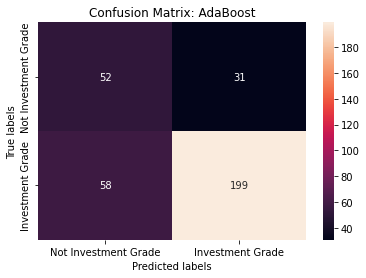

In [ ]:
c = confusion_matrix(y_test, y_pred)
ax= plt.subplot()

sns.heatmap(c, annot=True, fmt = 'g', ax=ax);  
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: AdaBoost'); 
ax.xaxis.set_ticklabels(['Not Investment Grade', 'Investment Grade']); 
ax.yaxis.set_ticklabels(['Not Investment Grade', 'Investment Grade']);

In [ ]:
#Try Random Forest
rf = RandomForestClassifier()
parameters = [{'n_estimators':(100, 200, 300, 400, 500, 750, 1000, 1500, 2000)}]
rf_clf = GridSearchCV(rf, parameters)
rf_clf.fit(X_train_sc, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [ ]:
rf_clf.best_params_

{'n_estimators': 400}

In [ ]:
rf_best = RandomForestClassifier(**rf_clf.best_params_).fit(X_train_sc, y_train)
y_pred = rf_best.predict(X_test_sc)
print("TEST PERFORMANCE")
print(classification_report(y_test, y_pred, target_names = ['Not Invest Grade', 'Invest Grade']))

TEST PERFORMANCE
                  precision    recall  f1-score   support

Not Invest Grade       0.69      0.81      0.74        83
    Invest Grade       0.93      0.88      0.91       257

        accuracy                           0.86       340
       macro avg       0.81      0.85      0.83       340
    weighted avg       0.87      0.86      0.87       340



In [ ]:
y_pred_t = rf_best.predict(X_train_sc)
print("TRAINING PERFORMANCE")
print(classification_report(y_train, y_pred_t, target_names = ['Not Invest Grade', 'Invest Grade']))

TRAINING PERFORMANCE
                  precision    recall  f1-score   support

Not Invest Grade       1.00      1.00      1.00      1030
    Invest Grade       1.00      1.00      1.00      1030

        accuracy                           1.00      2060
       macro avg       1.00      1.00      1.00      2060
    weighted avg       1.00      1.00      1.00      2060



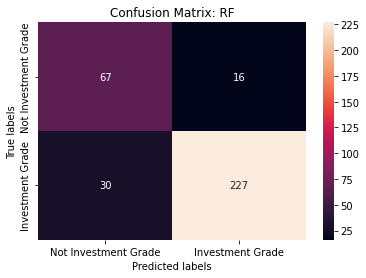

In [ ]:
c = confusion_matrix(y_test, y_pred)
ax= plt.subplot()

sns.heatmap(c, annot=True, fmt = 'g', ax=ax);  
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: RF'); 
ax.xaxis.set_ticklabels(['Not Investment Grade', 'Investment Grade']); 
ax.yaxis.set_ticklabels(['Not Investment Grade', 'Investment Grade']);

In [ ]:
#Try SVC
svc = SVC()
parameters = [{'C':(0.1, 0.2, 0.5,  1.0, 1.5, 2.0), 'kernel':('linear', 'poly', 'rbf'), 'degree':(2,3,4)}]
svc_clf = GridSearchCV(svc, parameters)
svc_clf.fit(X_train_sc, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': (0.1, 0.2, 0.5, 1.0, 1.5, 2.0),
                          'degree': (2, 3, 4),
                          'kernel': ('linear', 'poly', 'rbf')}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
svc_clf.best_params_

{'C': 2.0, 'degree': 2, 'kernel': 'rbf'}

In [ ]:
svc_best = SVC(**svc_clf.best_params_).fit(X_train_sc, y_train)
y_pred = svc_best.predict(X_test_sc)
print("TEST PERFORMANCE")
print(classification_report(y_test, y_pred, target_names = ['Not Invest Grade', 'Invest Grade']))

TEST PERFORMANCE
                  precision    recall  f1-score   support

Not Invest Grade       0.46      0.49      0.48        83
    Invest Grade       0.83      0.81      0.82       257

        accuracy                           0.74       340
       macro avg       0.65      0.65      0.65       340
    weighted avg       0.74      0.74      0.74       340



In [ ]:
y_pred_t = svc_best.predict(X_train_sc)
print("TRAINING PERFORMANCE")
print(classification_report(y_train, y_pred_t, target_names = ['Not Invest Grade', 'Invest Grade']))

TRAINING PERFORMANCE
                  precision    recall  f1-score   support

Not Invest Grade       0.84      0.53      0.65      1030
    Invest Grade       0.66      0.90      0.76      1030

        accuracy                           0.72      2060
       macro avg       0.75      0.72      0.71      2060
    weighted avg       0.75      0.72      0.71      2060



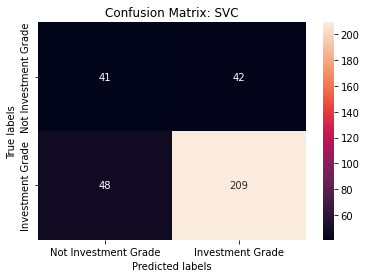

In [ ]:
c = confusion_matrix(y_test, y_pred)
ax= plt.subplot()

sns.heatmap(c, annot=True, fmt = 'g', ax=ax);  
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: SVC'); 
ax.xaxis.set_ticklabels(['Not Investment Grade', 'Investment Grade']); 
ax.yaxis.set_ticklabels(['Not Investment Grade', 'Investment Grade']);

## Binary with PCA

###PCA: try with as many components as it wants

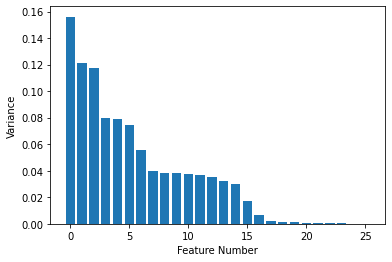

In [ ]:
pca = PCA(n_components = None)
X_train_pca = pca.fit_transform(X_train_sc)
exp_var_pca1 = pca.explained_variance_ratio_

plt.bar(range(pca.n_components_), exp_var_pca1)
plt.xlabel('Feature Number')
plt.ylabel('Variance')
plt.show()

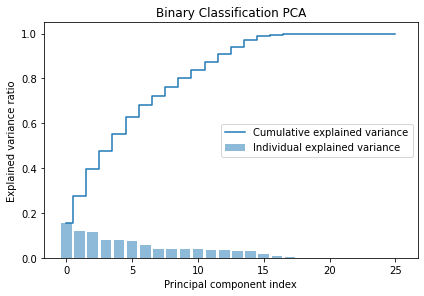

In [ ]:
cum_sum_eigenvalues1 = np.cumsum(exp_var_pca1)

plt.bar(range(0,len(exp_var_pca1)), exp_var_pca1, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues1)), cum_sum_eigenvalues1, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.title("Binary Classification PCA")
plt.show()

###PCA: Pick 16 components, fit & use going forward

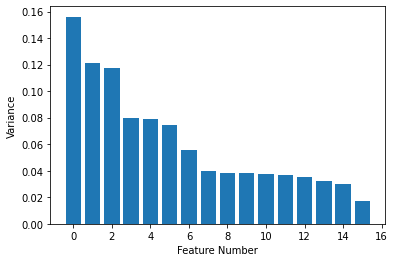

In [ ]:
pca = PCA(n_components = 16)
X_train_pca = pca.fit_transform(X_train_sc)
exp_var_pca1 = pca.explained_variance_ratio_

plt.bar(range(pca.n_components_), exp_var_pca1)
plt.xlabel('Feature Number')
plt.ylabel('Variance')
plt.show()

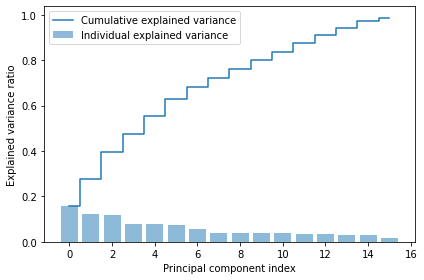

In [ ]:
cum_sum_eigenvalues1 = np.cumsum(exp_var_pca1)

plt.bar(range(0,len(exp_var_pca1)), exp_var_pca1, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues1)), cum_sum_eigenvalues1, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
#Try AdaBoost
tree = DecisionTreeClassifier(max_depth = 1)
ada = AdaBoostClassifier(tree)
parameters = [{'n_estimators':(100, 200, 300, 400, 500, 750, 1000, 1500, 2000)}]
ada_clf = GridSearchCV(ada, parameters)
ada_clf.fit(X_train_pca, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=1,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
 

In [ ]:
ada_clf.best_params_

{'n_estimators': 1500}

In [ ]:
ada_best = AdaBoostClassifier(**ada_clf.best_params_).fit(X_train_pca, y_train)
X_test_pca = pca.transform(X_test_sc)
y_pred = ada_best.predict(X_test_pca)
print("TEST PERFORMANCE")
print(classification_report(y_test, y_pred, target_names = ['Not Investment Grade', 'Investment Grade']))

TEST PERFORMANCE
                      precision    recall  f1-score   support

Not Investment Grade       0.40      0.66      0.50        83
    Investment Grade       0.86      0.68      0.76       257

            accuracy                           0.68       340
           macro avg       0.63      0.67      0.63       340
        weighted avg       0.75      0.68      0.70       340



In [ ]:
y_pred_t = ada_best.predict(X_train_pca)
print("TRAINING PERFORMANCE")
print(classification_report(y_train, y_pred_t, target_names = ['Not Invest Grade', 'Invest Grade']))

TRAINING PERFORMANCE
                  precision    recall  f1-score   support

Not Invest Grade       0.95      0.93      0.94      1030
    Invest Grade       0.93      0.95      0.94      1030

        accuracy                           0.94      2060
       macro avg       0.94      0.94      0.94      2060
    weighted avg       0.94      0.94      0.94      2060



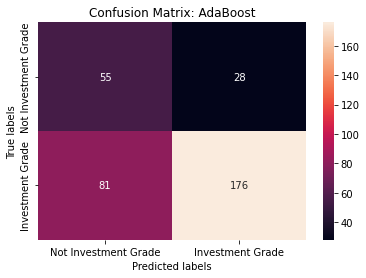

In [ ]:
c = confusion_matrix(y_test, y_pred)
ax= plt.subplot()

sns.heatmap(c, annot=True, fmt = 'g', ax=ax);  
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: AdaBoost'); 
ax.xaxis.set_ticklabels(['Not Investment Grade', 'Investment Grade']); 
ax.yaxis.set_ticklabels(['Not Investment Grade', 'Investment Grade']);

In [ ]:
#Try Random Forest
rf = RandomForestClassifier()
parameters = [{'n_estimators':(100, 200, 300, 400, 500, 750, 1000, 1500, 2000)}]
rf_clf = GridSearchCV(rf, parameters)
rf_clf.fit(X_train_pca, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [ ]:
rf_clf.best_params_

{'n_estimators': 750}

In [ ]:
rf_best = RandomForestClassifier(**rf_clf.best_params_).fit(X_train_pca, y_train)
X_test_pca = pca.transform(X_test_sc)
y_pred = rf_best.predict(X_test_pca)
print("TEST PERFORMANCE")
print(classification_report(y_test, y_pred, target_names = ['Not Investment Grade', 'Investment Grade']))

TEST PERFORMANCE
                      precision    recall  f1-score   support

Not Investment Grade       0.54      0.60      0.57        83
    Investment Grade       0.87      0.84      0.85       257

            accuracy                           0.78       340
           macro avg       0.71      0.72      0.71       340
        weighted avg       0.79      0.78      0.78       340



In [ ]:
y_pred_t = rf_best.predict(X_train_pca)
print("TRAINING PERFORMANCE")
print(classification_report(y_train, y_pred_t, target_names = ['Not Invest Grade', 'Invest Grade']))

TRAINING PERFORMANCE
                  precision    recall  f1-score   support

Not Invest Grade       1.00      1.00      1.00      1030
    Invest Grade       1.00      1.00      1.00      1030

        accuracy                           1.00      2060
       macro avg       1.00      1.00      1.00      2060
    weighted avg       1.00      1.00      1.00      2060



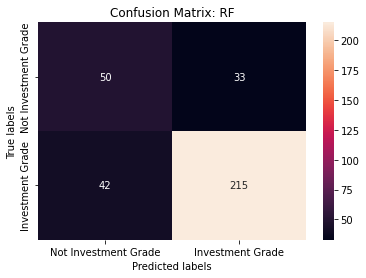

In [ ]:
c = confusion_matrix(y_test, y_pred)
ax= plt.subplot()

sns.heatmap(c, annot=True, fmt = 'g', ax=ax);  
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: RF'); 
ax.xaxis.set_ticklabels(['Not Investment Grade', 'Investment Grade']); 
ax.yaxis.set_ticklabels(['Not Investment Grade', 'Investment Grade']);

In [ ]:
#Try SVC
svc = SVC()
parameters = [{'C':(0.1, 0.2, 0.5,  1.0, 1.5, 2.0), 'kernel':('linear', 'poly', 'rbf'), 'degree':(2,3,4)}]
svc_clf = GridSearchCV(svc, parameters)
svc_clf.fit(X_train_pca, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': (0.1, 0.2, 0.5, 1.0, 1.5, 2.0),
                          'degree': (2, 3, 4),
                          'kernel': ('linear', 'poly', 'rbf')}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
svc_clf.best_params_

{'C': 2.0, 'degree': 2, 'kernel': 'rbf'}

In [ ]:
svc_best = SVC(**svc_clf.best_params_).fit(X_train_pca, y_train)
X_test_pca = pca.transform(X_test_sc)
y_pred = svc_best.predict(X_test_pca)
print("TEST PERFORMANCE")
print(classification_report(y_test, y_pred, target_names = ['Not Investment Grade', 'Investment Grade']))

TEST PERFORMANCE
                      precision    recall  f1-score   support

Not Investment Grade       0.46      0.49      0.48        83
    Investment Grade       0.83      0.81      0.82       257

            accuracy                           0.74       340
           macro avg       0.65      0.65      0.65       340
        weighted avg       0.74      0.74      0.74       340



In [ ]:
y_pred_t = svc_best.predict(X_train_pca)
print("TRAINING PERFORMANCE")
print(classification_report(y_train, y_pred_t, target_names = ['Not Invest Grade', 'Invest Grade']))

TRAINING PERFORMANCE
                  precision    recall  f1-score   support

Not Invest Grade       0.84      0.53      0.65      1030
    Invest Grade       0.66      0.90      0.76      1030

        accuracy                           0.72      2060
       macro avg       0.75      0.72      0.71      2060
    weighted avg       0.75      0.72      0.71      2060



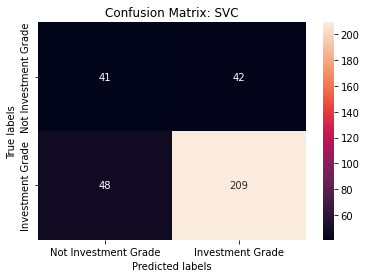

In [ ]:
c = confusion_matrix(y_test, y_pred)
ax= plt.subplot()

sns.heatmap(c, annot=True, fmt = 'g', ax=ax);  
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: SVC'); 
ax.xaxis.set_ticklabels(['Not Investment Grade', 'Investment Grade']); 
ax.yaxis.set_ticklabels(['Not Investment Grade', 'Investment Grade']);

## Multi-class model

By binning the investment grades into 4 buckets: A-Grade, Upper-B, Lower-B, and Below C


In [ ]:
#Let's add class numbers to the Ratings column and create buckets
df['Class_ID'] = np.nan
df['Rating'].value_counts()

Baa2    326
Baa3    232
Baa1    179
Aa3     174
A2      156
Ba2     125
A1      122
Ba3     108
B1       69
Aa2      65
B2       48
B3       37
A3       31
Ba1      17
Caa1      9
Aaa       2
Name: Rating, dtype: int64

In [ ]:
for index, row in df.iterrows():
  if df.loc[index, "Rating"] in ('A1', 'A2', 'A3', 'Aa2', 'Aa3', 'Aaa'):
    df.loc[index, 'Class_ID'] = 1
  elif df.loc[index, "Rating"] in ('Baa1', 'Baa2', 'Baa3') :
    df.loc[index, 'Class_ID'] = 2
  elif df.loc[index, "Rating"] in ('B1', 'B2', 'B3', 'Ba1','Ba2', 'Ba3'):
    df.loc[index, 'Class_ID'] = 3
  else:
    df.loc[index, 'Class_ID'] = 4
df.head()

,Sales/Revenues,Gross Margin,EBITDA,EBITDA Margin,Net Income Before Extras,Total Debt,Net Debt,LT Debt,ST Debt,Cash,Free Cash Flow,Total Debt/EBITDA,Net Debt/EBITDA,Total MV,Total Debt/MV,Net Debt/MV,CFO/Debt,CFO,Interest Coverage,Total Liquidity,Current Liquidity,Current Liabilities,EPS Before Extras,PE,ROA,ROE,InvGrd,Rating,Class_ID
0,-0.005496,0.030763,0.018885,0.024515,0.146849,-0.029710,-0.019296,-0.042648,0.049875,-0.133716,0.352997,-0.047694,-0.037474,0.263605,-0.232129,-0.223883,0.101245,0.068526,0.136748,0.392143,-0.184887,0.062781,0.148305,0.100409,0.163266,0.102521,1,A1,1.0
1,-0.005496,0.030763,0.088716,0.094733,0.146849,-0.029710,-0.019296,-0.042648,0.049875,-0.133716,0.352997,-0.108776,-0.099211,0.045420,-0.071864,-0.061909,0.101245,0.068526,0.214657,0.392143,-0.184887,0.062781,0.148305,-0.089598,0.163266,0.102521,1,A1,1.0
2,-0.007045,0.023159,0.088716,0.096440,0.108590,0.039410,0.034268,0.009059,0.250371,0.101315,0.500174,-0.045288,-0.050011,0.060519,-0.019903,-0.024748,0.027638,0.068136,0.205290,0.483257,-0.017877,0.121357,0.110656,-0.045142,0.105711,0.103378,1,A1,1.0
3,-0.009396,0.028400,0.088716,0.099046,0.146137,0.030071,0.036938,-0.016964,0.356994,-0.052606,0.551592,-0.053866,-0.047559,0.142160,-0.098139,-0.092127,0.042437,0.073784,0.232991,0.996955,-0.122017,0.079051,0.151639,-0.008231,0.162421,0.132295,1,A1,1.0
4,-0.009009,0.027714,0.088716,0.098611,0.123500,0.024224,0.034445,-0.034132,0.461894,-0.090869,0.753321,-0.059237,-0.049849,0.147989,-0.107808,-0.098904,0.106052,0.132845,0.172906,1.711426,-0.161561,0.084319,0.130435,0.015528,0.156427,0.225144,1,A1,1.0


In [ ]:
print(df.groupby(['Class_ID']).count())

          Sales/Revenues  Gross Margin  EBITDA  ...  ROE  InvGrd  Rating
Class_ID                                        ...                     
1.0                  550           550     550  ...  550     550     550
2.0                  737           737     737  ...  737     737     737
3.0                  404           404     404  ...  404     404     404
4.0                    9             9       9  ...    9       9       9

[4 rows x 28 columns]


In [ ]:
#Set up X and Y columns
X = df.drop(columns = ['InvGrd', 'Rating', 'Class_ID'])
Y = df['Class_ID']

In [ ]:
#Test-Train Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify = Y)

In [ ]:
# summarize class distribution
counter = Counter(y_train)
print(counter)

Counter({2.0: 590, 1.0: 440, 3.0: 323, 4.0: 7})


In [ ]:
# transform the dataset
oversample = SMOTE(random_state=12)
X_train, y_train = oversample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# summarize the new class distribution
counter_SMOTE = Counter(y_train)
print(counter_SMOTE)

Counter({1.0: 590, 3.0: 590, 2.0: 590, 4.0: 590})


In [ ]:
#Scale first
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [ ]:
#Then fit LDA
lda = LDA(n_components = 3)
X_train_lda = lda.fit_transform(X_train_sc, y_train)
print('Explained variance ratio: ', lda.explained_variance_ratio_)

Explained variance ratio:  [0.65820142 0.26023862 0.08155996]


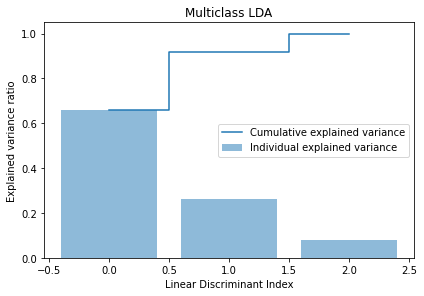

In [ ]:
cum_sum_eigenvalues1 = np.cumsum(lda.explained_variance_ratio_)

plt.bar(range(0,len(lda.explained_variance_ratio_)), lda.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues1)), cum_sum_eigenvalues1, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Linear Discriminant Index')
plt.legend(loc='best')
plt.tight_layout()
plt.title("Multiclass LDA")
plt.show()

In [ ]:
#Try AdaBoost
tree = DecisionTreeClassifier(max_depth = 1)
ada = AdaBoostClassifier(tree)
parameters = [{'n_estimators':(100, 200, 300, 400, 500, 750, 1000, 1500, 2000)}]
ada_clf = GridSearchCV(ada, parameters)
ada_clf.fit(X_train_lda, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=1,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
 

In [ ]:
ada_clf.best_params_

{'n_estimators': 100}

In [ ]:
ada_best = AdaBoostClassifier(**ada_clf.best_params_).fit(X_train_lda, y_train)
X_test_lda = lda.transform(X_test_sc)
y_pred = ada_best.predict(X_test_lda)
print("TEST PERFORMANCE")
print(classification_report(y_test, y_pred, target_names = ['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']))

TEST PERFORMANCE
               precision    recall  f1-score   support

      A Grade       0.33      0.17      0.23       110
Upper B Grade       0.46      0.44      0.45       147
Lower B Grade       0.26      0.38      0.31        81
      C Grade       0.00      0.00      0.00         2

     accuracy                           0.34       340
    macro avg       0.26      0.25      0.25       340
 weighted avg       0.37      0.34      0.34       340



In [ ]:
y_pred_t = ada_best.predict(X_train_lda)
print("TRAINING PERFORMANCE")
print(classification_report(y_train, y_pred_t, target_names = ['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']))

TRAINING PERFORMANCE
               precision    recall  f1-score   support

      A Grade       0.38      0.22      0.28       590
Upper B Grade       0.37      0.48      0.42       590
Lower B Grade       0.34      0.38      0.36       590
      C Grade       0.86      0.88      0.87       590

     accuracy                           0.49      2360
    macro avg       0.49      0.49      0.48      2360
 weighted avg       0.49      0.49      0.48      2360



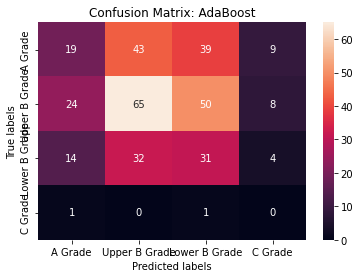

In [ ]:
c = confusion_matrix(y_test, y_pred)
ax= plt.subplot()

sns.heatmap(c, annot=True, fmt = 'g', ax=ax);  
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: AdaBoost'); 
ax.xaxis.set_ticklabels(['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']); 
ax.yaxis.set_ticklabels(['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']);

In [ ]:
#Try Random Forest
rf = RandomForestClassifier()
parameters = [{'n_estimators':(100, 200, 300, 400, 500, 750, 1000, 1500, 2000)}]
rf_clf = GridSearchCV(rf, parameters)
rf_clf.fit(X_train_lda, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [ ]:
rf_clf.best_params_

{'n_estimators': 750}

In [ ]:
rf_best = RandomForestClassifier(**rf_clf.best_params_).fit(X_train_lda, y_train)
X_test_lda = lda.transform(X_test_sc)
y_pred = rf_best.predict(X_test_lda)
print("TEST PERFORMANCE")
print(classification_report(y_test, y_pred, target_names = ['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']))

TEST PERFORMANCE
               precision    recall  f1-score   support

      A Grade       0.52      0.55      0.53       110
Upper B Grade       0.53      0.42      0.47       147
Lower B Grade       0.42      0.47      0.44        81
      C Grade       0.00      0.00      0.00         2

     accuracy                           0.47       340
    macro avg       0.37      0.36      0.36       340
 weighted avg       0.50      0.47      0.48       340



In [ ]:
y_pred_t = ada_best.predict(X_train_lda)
print("TRAINING PERFORMANCE")
print(classification_report(y_train, y_pred_t, target_names = ['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']))

TRAINING PERFORMANCE
               precision    recall  f1-score   support

      A Grade       0.38      0.22      0.28       590
Upper B Grade       0.37      0.48      0.42       590
Lower B Grade       0.34      0.38      0.36       590
      C Grade       0.86      0.88      0.87       590

     accuracy                           0.49      2360
    macro avg       0.49      0.49      0.48      2360
 weighted avg       0.49      0.49      0.48      2360



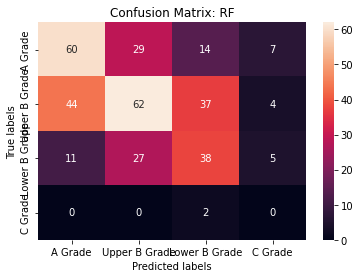

In [ ]:
c = confusion_matrix(y_test, y_pred)
ax= plt.subplot()

sns.heatmap(c, annot=True, fmt = 'g', ax=ax);  
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: RF'); 
ax.xaxis.set_ticklabels(['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']); 
ax.yaxis.set_ticklabels(['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']);

In [ ]:
#Try SVC
svc = SVC()
parameters = [{'C':(0.1, 0.2, 0.5,  1.0, 1.5, 2.0), 'kernel':('linear', 'poly', 'rbf'), 'degree':(2,3,4)}]
svc_clf = GridSearchCV(svc, parameters)
svc_clf.fit(X_train_lda, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': (0.1, 0.2, 0.5, 1.0, 1.5, 2.0),
                          'degree': (2, 3, 4),
                          'kernel': ('linear', 'poly', 'rbf')}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
svc_clf.best_params_

{'C': 2.0, 'degree': 2, 'kernel': 'rbf'}

In [ ]:
svc_best = SVC(**svc_clf.best_params_).fit(X_train_lda, y_train)
X_test_lda = lda.transform(X_test_sc)
y_pred = svc_best.predict(X_test_lda)
print("TEST PERFORMANCE")
print(classification_report(y_test, y_pred, target_names = ['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']))

TEST PERFORMANCE
               precision    recall  f1-score   support

      A Grade       0.44      0.65      0.53       110
Upper B Grade       0.60      0.28      0.38       147
Lower B Grade       0.50      0.41      0.45        81
      C Grade       0.02      0.50      0.05         2

     accuracy                           0.43       340
    macro avg       0.39      0.46      0.35       340
 weighted avg       0.52      0.43      0.44       340



In [ ]:
y_pred_t = svc_best.predict(X_train_lda)
print("TRAINING PERFORMANCE")
print(classification_report(y_train, y_pred_t, target_names = ['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']))

TRAINING PERFORMANCE
               precision    recall  f1-score   support

      A Grade       0.47      0.75      0.58       590
Upper B Grade       0.62      0.33      0.43       590
Lower B Grade       0.67      0.43      0.53       590
      C Grade       0.75      0.91      0.82       590

     accuracy                           0.61      2360
    macro avg       0.63      0.61      0.59      2360
 weighted avg       0.63      0.61      0.59      2360



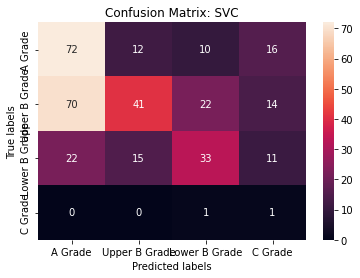

In [ ]:
c = confusion_matrix(y_test, y_pred)
ax= plt.subplot()

sns.heatmap(c, annot=True, fmt = 'g', ax=ax);  
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: SVC'); 
ax.xaxis.set_ticklabels(['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']); 
ax.yaxis.set_ticklabels(['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']);

## Try without LDA

In [ ]:
#Try AdaBoost
tree = DecisionTreeClassifier(max_depth = 1)
ada = AdaBoostClassifier(tree)
parameters = [{'n_estimators':(100, 200, 300, 400, 500, 750, 1000, 1500, 2000)}]
ada_clf = GridSearchCV(ada, parameters)
ada_clf.fit(X_train_sc, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=1,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
 

In [ ]:
ada_clf.best_params_

{'n_estimators': 2000}

In [ ]:
ada_best = AdaBoostClassifier(**ada_clf.best_params_).fit(X_train_sc, y_train)
y_pred = ada_best.predict(X_test_sc)
print("TEST PERFORMANCE")
print(classification_report(y_test, y_pred, target_names = ['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']))

TEST PERFORMANCE
               precision    recall  f1-score   support

      A Grade       0.42      0.66      0.51       110
Upper B Grade       0.55      0.20      0.29       147
Lower B Grade       0.38      0.52      0.44        81
      C Grade       0.00      0.00      0.00         2

     accuracy                           0.42       340
    macro avg       0.34      0.34      0.31       340
 weighted avg       0.46      0.42      0.40       340



In [ ]:
y_pred_t = ada_best.predict(X_train_sc)
print("TRAINING PERFORMANCE")
print(classification_report(y_train, y_pred_t, target_names = ['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']))

TRAINING PERFORMANCE
               precision    recall  f1-score   support

      A Grade       0.47      0.70      0.56       590
Upper B Grade       0.49      0.19      0.27       590
Lower B Grade       0.49      0.58      0.53       590
      C Grade       0.99      0.91      0.95       590

     accuracy                           0.60      2360
    macro avg       0.61      0.60      0.58      2360
 weighted avg       0.61      0.60      0.58      2360



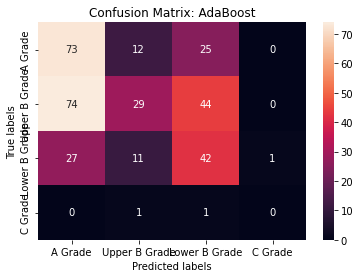

In [ ]:
c = confusion_matrix(y_test, y_pred)
ax= plt.subplot()

sns.heatmap(c, annot=True, fmt = 'g', ax=ax);  
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: AdaBoost'); 
ax.xaxis.set_ticklabels(['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']); 
ax.yaxis.set_ticklabels(['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']);

In [ ]:
#Try Random Forest
rf = RandomForestClassifier()
parameters = [{'n_estimators':(100, 200, 300, 400, 500, 750, 1000, 1500, 2000)}]
rf_clf = GridSearchCV(rf, parameters)
rf_clf.fit(X_train_sc, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [ ]:
rf_clf.best_params_

{'n_estimators': 300}

In [ ]:
rf_best = RandomForestClassifier(**rf_clf.best_params_).fit(X_train_sc, y_train)
y_pred = rf_best.predict(X_test_sc)
print("TEST PERFORMANCE")
print(classification_report(y_test, y_pred, target_names = ['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']))

TEST PERFORMANCE
               precision    recall  f1-score   support

      A Grade       0.75      0.78      0.76       110
Upper B Grade       0.80      0.76      0.78       147
Lower B Grade       0.76      0.80      0.78        81
      C Grade       0.00      0.00      0.00         2

     accuracy                           0.77       340
    macro avg       0.58      0.59      0.58       340
 weighted avg       0.77      0.77      0.77       340



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred_t = rf_best.predict(X_train_sc)
print("TRAINING PERFORMANCE")
print(classification_report(y_train, y_pred_t, target_names = ['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']))

TRAINING PERFORMANCE
               precision    recall  f1-score   support

      A Grade       1.00      1.00      1.00       590
Upper B Grade       1.00      1.00      1.00       590
Lower B Grade       1.00      1.00      1.00       590
      C Grade       1.00      1.00      1.00       590

     accuracy                           1.00      2360
    macro avg       1.00      1.00      1.00      2360
 weighted avg       1.00      1.00      1.00      2360



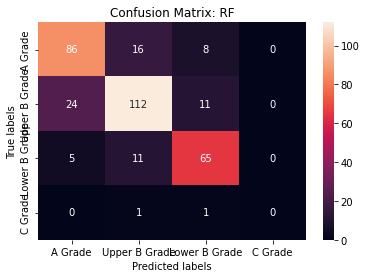

In [ ]:
c = confusion_matrix(y_test, y_pred)
ax= plt.subplot()

sns.heatmap(c, annot=True, fmt = 'g', ax=ax);  
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: RF'); 
ax.xaxis.set_ticklabels(['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']); 
ax.yaxis.set_ticklabels(['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']);

In [ ]:
#Try SVC
svc = SVC()
parameters = [{'C':(0.1, 0.2, 0.5,  1.0, 1.5, 2.0), 'kernel':('linear', 'poly', 'rbf'), 'degree':(2,3,4)}]
svc_clf = GridSearchCV(svc, parameters)
svc_clf.fit(X_train_sc, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': (0.1, 0.2, 0.5, 1.0, 1.5, 2.0),
                          'degree': (2, 3, 4),
                          'kernel': ('linear', 'poly', 'rbf')}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
svc_clf.best_params_

{'C': 2.0, 'degree': 2, 'kernel': 'rbf'}

In [ ]:
svc_best = SVC(**svc_clf.best_params_).fit(X_train_sc, y_train)
y_pred = svc_best.predict(X_test_sc)
print("TEST PERFORMANCE")
print(classification_report(y_test, y_pred, target_names = ['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']))

TEST PERFORMANCE
               precision    recall  f1-score   support

      A Grade       0.47      0.85      0.60       110
Upper B Grade       0.60      0.26      0.36       147
Lower B Grade       0.55      0.44      0.49        81
      C Grade       0.00      0.00      0.00         2

     accuracy                           0.49       340
    macro avg       0.41      0.39      0.36       340
 weighted avg       0.54      0.49      0.47       340



In [ ]:
y_pred_t = svc_best.predict(X_train_sc)
print("TRAINING PERFORMANCE")
print(classification_report(y_train, y_pred_t, target_names = ['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']))

TRAINING PERFORMANCE
               precision    recall  f1-score   support

      A Grade       0.48      0.87      0.62       590
Upper B Grade       0.67      0.35      0.46       590
Lower B Grade       0.79      0.46      0.58       590
      C Grade       0.91      1.00      0.95       590

     accuracy                           0.67      2360
    macro avg       0.71      0.67      0.65      2360
 weighted avg       0.71      0.67      0.65      2360



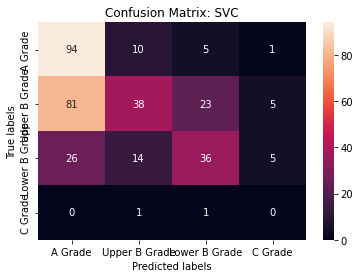

In [ ]:
c = confusion_matrix(y_test, y_pred)
ax= plt.subplot()

sns.heatmap(c, annot=True, fmt = 'g', ax=ax);  
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: SVC'); 
ax.xaxis.set_ticklabels(['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']); 
ax.yaxis.set_ticklabels(['A Grade', 'Upper B Grade', 'Lower B Grade', 'C Grade']);